In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')
sys.path.append('..')
import tools
import geopandas as gpd

In [2]:
from HEC_runs.fit_fia_logbiomass_logspp_GLS import prepareDataFrame, createMaternVariogram, buildSpatialStructure, calculateGLS

In [21]:
new_data = prepareDataFrame("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")
gvg,tt = createMaternVariogram("/apps/external_plugins/spystats/HEC_runs/results/logbiomas_logsppn_res.csv",new_data)

INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reading the empirical Variogram file
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Instantiating a Variogram object with the values calculated before
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Dropping possible Nans
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Instantiating Matern Model...
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:fitting Matern Model with the empirical variogram
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Matern Model fitted


new_data['residuals1'] = results.resid

## Subseting the data

Three different methods for subsetting the data.
1. Using a systematic selection by index modulus
2. Using a random uniform selection by indices.
2. A geographic subselection (Clip)

### Systematic selection

In [22]:
def systSelection(n,k):
    idxs = range(0,n,k)
    systematic_sample = new_data.iloc[idxs]
    return systematic_sample
##################
n = len(new_data)
k = 10 # The k-th element to take as a sample

In [23]:
systematic_sample = systSelection(n,k)

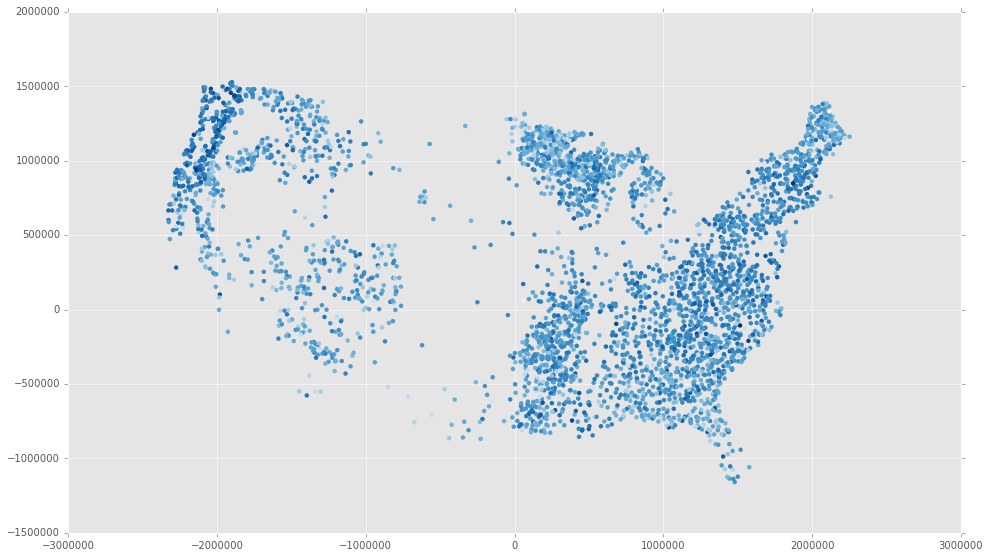

In [24]:
ax= systematic_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 

### Random (Uniform) selection


In [25]:
def randomSelection(n,p):
    idxs = np.random.choice(n,p,replace=True)
    random_sample = new_data.iloc[idxs]
    return random_sample
#################
n = len(new_data)
p = 3000 # The amount of samples taken (let's do it without replacement)

In [26]:
random_sample = randomSelection(n,p)

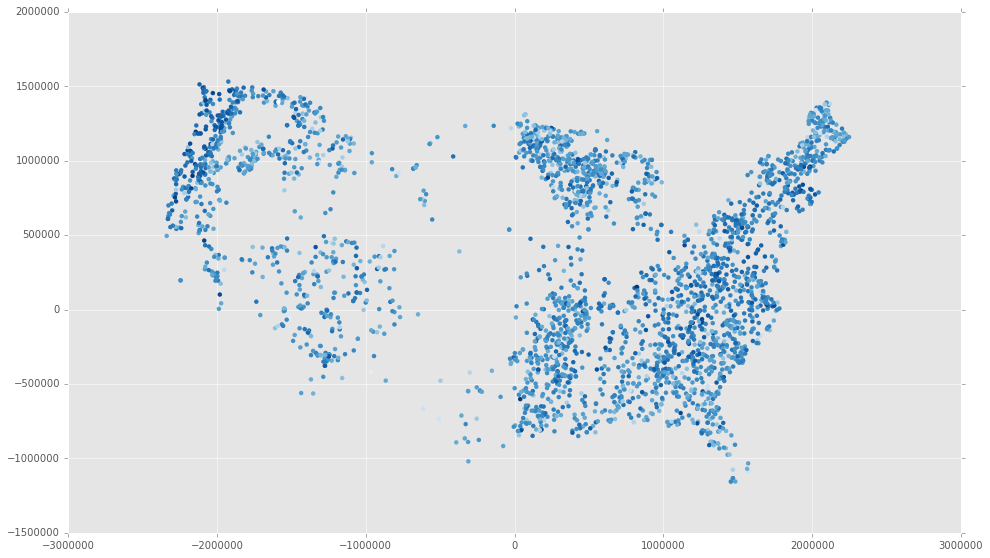

In [27]:
ax= random_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 


### Geographic subselection

In [28]:
def subselectDataFrameByCoordinates(dataframe,namecolumnx,namecolumny,minx,maxx,miny,maxy):
    """
    Returns a subselection by coordinates using the dataframe/
    """
    minx = float(minx)
    maxx = float(maxx)
    miny = float(miny)
    maxy = float(maxy)
    section = dataframe[lambda x:  (x[namecolumnx] > minx) & (x[namecolumnx] < maxx) & (x[namecolumny] > miny) & (x[namecolumny] < maxy) ]
    return section

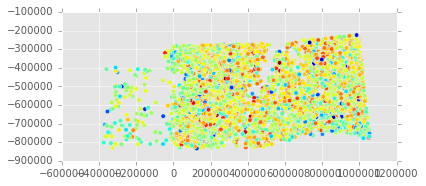

In [29]:
# COnsider the the following subregion
minx = -100
maxx = -85
miny = 30
maxy = 35

section = subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)

#section = new_data[lambda x:  (x.LON > minx) & (x.LON < maxx) & (x.LAT > miny) & (x.LAT < maxy) ]
section.plot(column='logBiomass')



## Model Analysis with the empirical variogram


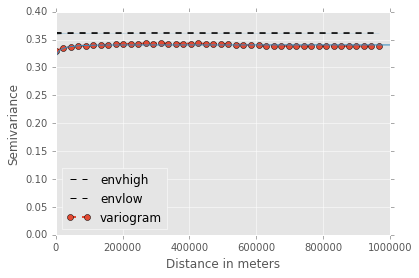

In [30]:
import numpy as np
xx = np.linspace(0,1000000,1000)
gvg.plot(refresh=False)
plt.plot(xx,gvg.model.f(xx))

In [31]:
whittle_model = tools.WhittleVariogram(sill=0.34,range_a=100000,nugget=0.0,alpha=3)

In [32]:
gvg.model = whittle_model

In [33]:
gvg.fitVariogramModel(whittle_model)

../tools.py:549: RuntimeWarning: divide by zero encountered in power
  g_h = ((sill - nugget)*(1 - np.exp(-(h**alpha / range_a**alpha)))) + nugget*Ih


< Whittle Variogram : sill 0.340274656891, range 41061.6971399, nugget 0.329817414704, alpha1.12113685018 >

In [34]:
%time CovMatrs = buildSpatialStructure(systematic_sample,gvg.model)

INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Calculating Distance Matrix


CPU times: user 1min 28s, sys: 556 ms, total: 1min 28s
Wall time: 1min 28s


In [35]:
CovMatrs.diagonal()

array([ 0.34027466,  0.34027466,  0.34027466, ...,  0.34027466,
        0.34027466,  0.34027466])

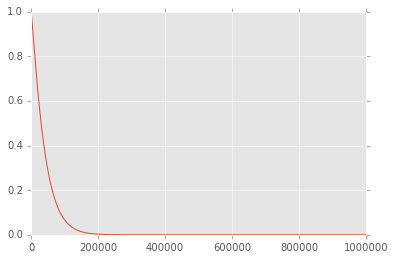

In [36]:
import numpy as np
xx = np.linspace(0,1000000,1000)
plt.plot(xx,gvg.model.corr_f(xx))

In [37]:
%time results,resum = calculateGLS(systematic_sample,CovMatrs)

INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Fitting linear model using GLS


CPU times: user 1min 9s, sys: 764 ms, total: 1min 9s
Wall time: 19.1 s


In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.572
Model:                            GLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     4913.
Date:                Tue, 16 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:27:20   Log-Likelihood:                -3621.1
No. Observations:                3685   AIC:                             7246.
Df Residuals:                    3683   BIC:                             7259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.5120      0.028    304.803      0.000         8.457     8.567
logSppN        0.3617      0.017     20.888      0.000         0.328     0.396
==============================================================================
Omnibus:                      122.188   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.481
Skew:                          -0.363   Prob(JB):                     8.61e-36
Kurtosis:                       3.724   Cond. No.                         5.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Global Variogram
Calculated previously. Here I want to check if by taking some of these subsamples is possible to capture the spatial structure.

In [ ]:
thrs_dist = 600000
nt = 30 # num iterations
filename = "../HEC_runs/results/logbiomas_logsppn_res.csv"
#filename = "../HEC_runs/results/low_q/data_envelope.csv"
envelope_data = pd.read_csv(filename)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = envelope_data
gvg.empirical = gvg.envelope.variogram
gvg.lags = gvg.envelope.lags
vdata = gvg.envelope.dropna()
gvg.plot(refresh=False,legend=False)


In [ ]:
## For systematic sample
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

In [ ]:
## For systematic sample
systsamps = map(lambda k : systSelection(n,k), range(5,30))
vgs = map(lambda sample : tools.Variogram(sample,'logBiomass',using_distance_threshold=thrs_dist),systsamps)
emps = map(lambda vg : vg.calculateEmpirical(),vgs)

In [ ]:
d = pd.concat([vgs[0].lags,pd.DataFrame(emps).transpose()],axis=1)


In [ ]:
d.variogram.plot(x=d.lags.values,legend=False)
gvg.plot(refresh=False,legend=False)

In [ ]:
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

## Fitting the empirical variogram to into a theoretical model

# Valid parametric empirical variogram
That, covariance matrix always postive semi-definite.
## Gaussian Model
$$\gamma (h)=(s-n)\left(1-\exp \left(-{\frac  {h^{2}}{r^{2}a}}\right)\right)+n1_{{(0,\infty )}}(h)$$

In [ ]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    #Ih = 1.0 if h >= 0 else 0.0    
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget*Ih
    return g_h

## Exponential Model
$$\gamma (h)=(s-n)(1-\exp(-h/(ra)))+n1_{{(0,\infty )}}(h)$$

In [ ]:
def exponentialVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    g_h = (sill - nugget)*(1 - np.exp(-h/range_a)) #+ (nugget*Ih)
    return g_h

## Spherical Variogram
$$\gamma (h)=(s-n)\left(\left({\frac  {3h}{2r}}-{\frac  {h^{3}}{2r^{3}}}\right)1_{{(0,r)}}(h)+1_{{[r,\infty )}}(h)\right)+n1_{{(0,\infty )}}(h))$$

In [ ]:
def sphericalVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
        I0r = np.array([1.0 if hi <= range_a else 0.0 for hi in h])
        Irinf = [1.0 if hi > range_a else 0.0 for hi in h]
    else:
        Ih = 1.0 if h >= 0 else 0.0
        I0r = [1.0 if hi <= range_a else 0.0 for hi in h]
        Irinf = [1.0 if hi > range_a else 0.0 for hi in h]
    g_h = (sill - nugget)*((3*h / float(2*range_a))*I0r + Irinf) - (h**3 / float(2*range_a)) + (nugget*Ih)
    return g_h

# Matern Variogram of order $\kappa$


$$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$



Check this:$$\gamma (h) = \frac{1}{\Gamma (\kappa) 2^{\kappa - 1}}\Big[\frac{\sqrt{ 2 \kappa }}{r} h \Big]^\kappa K_{\kappa} \Big( \frac{\sqrt{2\kappa}}{r} h \Big)$$   

$$\rho(u;\phi,\kappa) =\{2^{\kappa-1}
    \Gamma(\kappa)\}^{-1} (u/\phi)^\kappa
    K_\kappa(u/\phi)$$
    
Where: $K_{\nu}$ is the Modified Bessel of second kind of order $\nu$

    

In [ ]:
## check the matern
import scipy.special as special
def MaternVariogram(h,range_a,kappa=0.5,sigma=100.0):
    """
    The Matern Variogram of order $\kappa$.
   
   $$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$
    Let:
         a = $$ 
        b = $$
        K_v = Modified Bessel function of the second kind of real order v
    """
    
    a = np.power(2, 1 - kappa) / special.gamma(kappa)
    #b = (np.sqrt(2 * kappa) / range_a) * h
    b = (h / float(range_a))
    K_v = special.kv(kappa,b)
    
    #kh = sigma * a * np.power(b,kappa) * K_v
    kh = sigma * (1 - (a * np.power(b,kappa) * K_v) )
    return kh
    

#cc = MaternVariogram(hx,100000)
#plt.plot(cc,'.')

In [ ]:

hx = np.linspace(0,600000,100)
vg = tools.Variogram(section,'residuals2',using_distance_threshold=500000)
#plt.figsize=(16,10)
gvg.plot(refresh=False,legend=False)

## already fitted previously
s = 0.345255240992
r = 65857.797111
nugget = 0.332850902482

In [ ]:
### Optimizing the empirical values
from scipy.optimize import curve_fit
s = 0.345
r = 100000.0
nugget = 0.33
init_vals = [0.34, 50000, 0.33]   

init_matern = [50000,0.5,0.34]
# for [amp, cen, wid]
bg, covar_gaussian = curve_fit(gaussianVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
be, covar_exp = curve_fit(exponentialVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
bs, covar_spher = curve_fit(sphericalVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
###
bestmatern,covar_matern = curve_fit(MaternVariogram,xdata=vdata.lags.values,ydata=vdata.variogram.values,p0=init_matern)
#gaussianVariogram(hx)
#s =best_vals[0]
#r = best_vals[1]
#nugget = best_vals[2]
#fitted_gaussianVariogram = lambda x : exponentialVariogram(x,sill=s,range_a=r,nugget=nugget)
#gammas = pd.DataFrame(map(fitted_gaussianVariogram,hx))
#import functools
#fitted_gaussian2 = functools.partial(gaussianVariogram,s,r,nugget)

In [ ]:
def theoreticalVariogram(model_function,sill,range_a,nugget):
    return lambda x : model_function(x,sill,range_a,nugget)

In [ ]:
gau_var = gaussianVariogram(hx,bg[0],bg[1],bg[2])
exp_var = exponentialVariogram(hx,be[0],be[1],be[2])
sph_var = sphericalVariogram(hx,bs[0],bs[1],bs[2])
matern_var = MaternVariogram(hx,bestmatern[0],bestmatern[1],bestmatern[2])
## The best is the gaussian
#model_var = theoreticalVariogram(gaussianVariogram,bg[0],bg[1],bg[2])

gvg.plot(refresh=False,legend=False)
plt.plot(hx,matern_var,color='green',lw=2.3)
#plt.plot(hx,exp_var)
#plt.plot(hx,sph_var)


## Model fitting with GLS

In [ ]:
import statsmodels.regression.linear_model as lm
Mdist = gvg.distance_coordinates.flatten()
%time vars = np.array(map(model_var,Mdist))
CovMat = vars.reshape(len(section),len(section))
X = section.logSppN.values
Y = section.logBiomass.values

In [ ]:
vars.shape

In [ ]:
plt.imshow(CovMat)

In [ ]:
%time model = lm.GLS(Y,X,sigma=CovMat)

In [ ]:
%time results = model.fit()

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data
$$\gamma (h) = \frac{1}{\Gamma (\kappa) 2^{\kappa - 1}}\Big[\frac{\sqrt{ 2 \kappa }}{r} h \Big]^\kappa K_{\kappa} \Big( \frac{\sqrt{2\kappa}}{r} h \Big)$$   


$$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$


source: http://www.sciencedirect.com/science/article/pii/S0098300408000666#bib5